# Algorithm 8 first version

In [1]:
import face_recognition
import cv2
import numpy as np
import matplotlib.pyplot as plt

We didn’t test this algorithm on the dataset due to the fact that the recognition is based on the frames captured from a webcam and this means that a real person has to be in front of it.
Ideally, we should have only one face model when we run this algorithm that is the one build on a video of the person that we want to recognise (old or new). We have carried out our experiment following this principle. In particular, we have trained the model on a video taken with the webcam directly or with a phone and then asking people to stay in front of the webcam to see if this algorithm can recognize them or not. We noticed a good ratio of correct recognition but we discovered that it also works only displaying videos and photos of the targeted person on the phone. For this reason, it is not reliable when we talk about “liveness” of the faces detected. 
For each test we compute two statistic:
* number of corrected detection over the total of the detection
* number of face detection over all frames

In [2]:
#global variables

known_face_encodings = []
known_face_names = []

def builModel(video_name):

    # This is an example of running face recognition on live video from your webcam. It's a little complicated and includes
    # some basic performance tweaks to make things run a lot faster:
    #   1. Process each video frame at 1/4 resolution (though still display it at full resolution)
    #   2. Only detect faces in every other frame of video.

    # PLEASE NOTE: This example requires OpenCV (the `cv2` library) to be installed only to read from your webcam.
    # OpenCV is *not* required to use the face_recognition library. It's only required if you want to run this
    # specific code.

    '''
    We take teh video precedently saved of the person that we want to recognize and from that we select
    a certain number of frame to build the model of the face. So we're going to have a vector of face model
    and a label for each face who is always the same.
    In this way during the recognition the only two possible label that we should find are "Subject1" or "Unknonw"
    To have a greater reliability we should take more frames and build more model but is also going to be slower
    '''

    User = "Subject1"
    video = cv2.VideoCapture(video_name)
    cnt = 0
    while(1):
        ret, frame = video.read()
        if ret == True:
            if cnt % 50 == 0:
                print(cnt)
                rgb_frame = frame[:, :, ::-1]
                #face_locations = face_recognition.face_locations(rgb_frame)
                try:
                    face_encodings = face_recognition.face_encodings(rgb_frame)[0]
                    known_face_encodings.append(face_encodings)

                    known_face_names.append(User)#always the same person

                except:   
                    print("No Face here")
            cnt +=1
        else:
            break

In [10]:
print(known_face_names)

['Subject1', 'Subject1', 'Subject1', 'Subject1', 'Subject1', 'Subject1', 'Subject1']


In [4]:
def startRecognition():
    
    # Initialize some variables
    face_locations = []
    face_encodings = []
    face_names = []
    process_this_frame = True
    unknown_c = 0
    correct_c = 0
    frames = 0

    # Get a reference to webcam #0 (the default one)
    video_capture = cv2.VideoCapture(0)


    while True:
        # Grab a single frame of video
        ret, frame = video_capture.read()
        frames += 1
        # Resize frame of video to 1/4 size for faster face recognition processing
        small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)

        # Convert the image from BGR color (which OpenCV uses) to RGB color (which face_recognition uses)
        rgb_small_frame = small_frame[:, :, ::-1]

        # Only process every other frame of video to save time
        if process_this_frame:
            # Find all the faces and face encodings in the current frame of video
            face_locations = face_recognition.face_locations(rgb_small_frame)
            face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)

            face_names = []
            for face_encoding in face_encodings:
                # See if the face is a match for the known face(s)
                matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
                name = "Unknown"

                # # If a match was found in known_face_encodings, just use the first one.
                # if True in matches:
                #     first_match_index = matches.index(True)
                #     name = known_face_names[first_match_index]

                # Or instead, use the known face with the smallest distance to the new face
                face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
                best_match_index = np.argmin(face_distances)
                if matches[best_match_index]:
                    name = known_face_names[best_match_index]
                    correct_c += 1
                else:
                    unknown_c += 1



                face_names.append(name)

        process_this_frame = not process_this_frame


        # Display the results
        for (top, right, bottom, left), name in zip(face_locations, face_names):
            # Scale back up face locations since the frame we detected in was scaled to 1/4 size
            top *= 4
            right *= 4
            bottom *= 4
            left *= 4

            # Draw a box around the face
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)

            # Draw a label with a name below the face
            cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)

        # Display the resulting image
        cv2.imshow('Video', frame)

        # Hit 'q' on the keyboard to quit!
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release handle to the webcam
    video_capture.release()
    cv2.destroyAllWindows()


    #computng metrics
    #how many time it detect a face in the video (correct or unknown)
    faces_detected = (unknown_c+correct_c)/frames
    #how many correct detect over all detected faces (correct + unknown)
    correct_detected = correct_c/(unknown_c+correct_c)
    #how many unknown detect over all detected faces (correct + unknown)
    not_correct_detected = unknown_c/(unknown_c+correct_c)
    
    #display metrics
    #-------------------------------------#
    labels = ['Correct Detected', 'Not Correct Detected']
    y = [correct_detected,not_correct_detected]
    esplodi = [0.0,0.0]
    fig, ax1 = plt.subplots()
    ax1.pie(y, labels=labels, explode=esplodi, autopct='%1.1f%%', startangle=90)
    ax1.set_title("Recognizing rateo")

    fig.tight_layout()
    
    
    
    #-------------------------------------#
    
    labels = ['Faces detected', 'Frames']
    y = [faces_detected,frames]
    esplodi = [0.0,0.5]
    fig, ax1 = plt.subplots()
    ax1.pie(y, labels=labels, explode=esplodi, autopct='%1.1f%%', startangle=90)
    ax1.set_title("Detecting rateo")

    fig.tight_layout()

## NOTE: sometimes we need to restart the kernel before the buildModel() to delete the variables of the previous recognition.

### Recognition of me based on my video (higher correct detection is better )

In [5]:
known_face_encodings = []
known_face_names = []
builModel('./Video/me.mp4')

0
50
100
150
200
250
300
No Face here
350


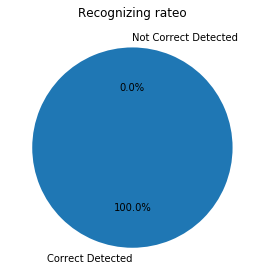

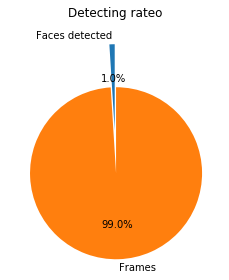

In [6]:
startRecognition()

We can notice that we have really good results if  the person in the video and in front of the webcam are the same

### Recognition of me based on a male video (lower correct detection is better )

In [9]:
known_face_encodings = []
known_face_names = []
builModel('./Video/fab.mp4')

0
50
100
150
200
No Face here
250
300
350


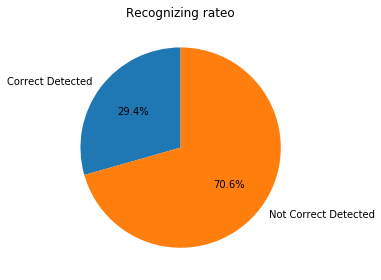

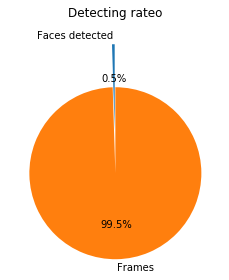

In [13]:
startRecognition()

This experiment is more difficulct for the algorithm because the two subject are different but share some common facial traits like beard, same color of the skin, the both have glasses etc.
In this case the algorithm seems to achieve a worst result than before classifing the person in front of the webcame the same as the videos even if it is not true.

### Recognition of me based on a female video  (lower correct detection is better )

In [7]:
known_face_encodings = []
known_face_names = []
builModel('./Video/mr.mp4')

0
50
100


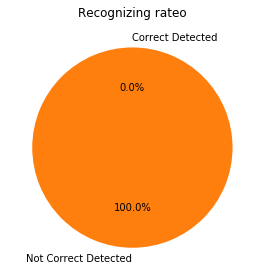

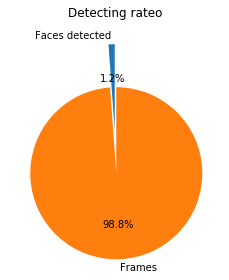

In [8]:
startRecognition()

We achieve a good result also if we try the algorithm on two different genders

In [29]:
# Release handle to the webcam--use in case of blocked webcam due to errors in the previous cells
video_capture = cv2.VideoCapture(0)
video_capture.release()
cv2.destroyAllWindows()